<a href="https://colab.research.google.com/github/TharinduGee/Prediction_Models/blob/test0---consider-correlation-of-dataset-only-numeric/Corbon_emission_predictor_Only_using_numeric_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import tensorflow as tf;

In [ ]:
record = pd.read_excel('https://www.epa.gov/system/files/documents/2022-04/22-tstcar-2022-04-15.xlsx');


In [ ]:
record = record.dropna(thresh = 3000, axis='columns')
record = record.fillna(method= 'ffill',axis='rows')


In [ ]:

train_record = record.sample(frac = 0.8, random_state = 3)
test_record = record.drop(train_record.index)

In [ ]:
numeric_feature_names = []
for name in record.columns:
  if record[name].dtype != object:
    numeric_feature_names.append(name)

numeric_feature_names

['Model Year',
 'Test Veh Configuration #',
 'Test Veh Displacement (L)',
 'Rated Horsepower',
 '# of Cylinders and Rotors',
 '# of Gears',
 'Transmission Overdrive Code',
 'Equivalent Test Weight (lbs.)',
 'Axle Ratio',
 'N/V Ratio',
 'Shift Indicator Light Use Cd',
 'Test Procedure Cd',
 'Test Fuel Type Cd',
 'THC (g/mi)',
 'CO (g/mi)',
 'CO2 (g/mi)',
 'NOx (g/mi)',
 'CH4 (g/mi)',
 'RND_ADJ_FE',
 'DT-Inertia Work Ratio Rating',
 'DT-Absolute Speed Change Ratg',
 'DT-Energy Economy Rating',
 'Target Coef A (lbf)',
 'Target Coef B (lbf/mph)',
 'Target Coef C (lbf/mph**2)',
 'Set Coef A (lbf)',
 'Set Coef B (lbf/mph)',
 'Set Coef C (lbf/mph**2)']

In [ ]:
numeric_feature_names=['Test Veh Displacement (L)','Rated Horsepower','# of Cylinders and Rotors','Transmission Overdrive Code','CO2 (g/mi)']
numeric_feature_names

['Test Veh Displacement (L)',
 'Rated Horsepower',
 '# of Cylinders and Rotors',
 'Transmission Overdrive Code',
 'CO2 (g/mi)']

In [ ]:
train_numeric_features = train_record[numeric_feature_names]
test_numeric_features = test_record[numeric_feature_names]


In [ ]:
train_numeric_features.corr()

,Test Veh Displacement (L),Rated Horsepower,# of Cylinders and Rotors,Transmission Overdrive Code,CO2 (g/mi)
Test Veh Displacement (L),1.000000,0.168753,0.172856,-0.201199,0.069833
Rated Horsepower,0.168753,1.000000,0.728027,-0.187900,0.536209
# of Cylinders and Rotors,0.172856,0.728027,1.000000,-0.006903,0.628001
Transmission Overdrive Code,-0.201199,-0.187900,-0.006903,1.000000,0.070394
CO2 (g/mi),0.069833,0.536209,0.628001,0.070394,1.000000


In [ ]:

train_target = train_numeric_features.pop("CO2 (g/mi)")
test_target = test_numeric_features.pop("CO2 (g/mi)")
train_numeric_features.head()

,Test Veh Displacement (L),Rated Horsepower,# of Cylinders and Rotors,Transmission Overdrive Code
1806,5.300,355,8.0,2
3525,3.445,416,6.0,2
1240,3.600,470,6.0,2
3129,5.600,400,8.0,2
3729,1.987,169,4.0,2


In [ ]:
tf.convert_to_tensor(train_numeric_features)

<tf.Tensor: shape=(3518, 4), dtype=float64, numpy=
array([[  5.3  , 355.   ,   8.   ,   2.   ],
       [  3.445, 416.   ,   6.   ,   2.   ],
       [  3.6  , 470.   ,   6.   ,   2.   ],
       ...,
       [  1.984, 242.   ,   4.   ,   2.   ],
       [  2.   , 228.   ,   4.   ,   2.   ],
       [  3.456, 295.   ,   6.   ,   2.   ]])>

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_numeric_features)

In [ ]:
normalizer(train_numeric_features.iloc[:3])

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.2778035 , 0.22277804, 1.4018264 , 0.25003886],
       [0.0084268 , 0.6005942 , 0.28846708, 0.25003886],
       [0.03093535, 0.9350544 , 0.28846708, 0.25003886]], dtype=float32)>

In [ ]:
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(56, activation='relu'),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  # model.compile(optimizer='adam',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
model = get_basic_model()
history = model.fit(train_numeric_features, train_target,validation_split = 0.2, verbose=4,  epochs=10, batch_size=2)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


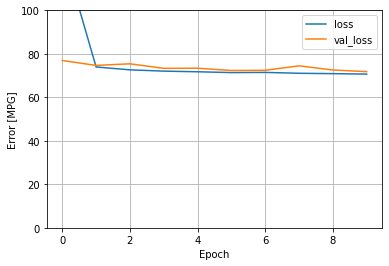

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
test_results = {}
test_results['dnn_model'] = model.evaluate(test_numeric_features, test_target, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [CO2 (g/mi)]']).T

,Mean absolute error [CO2 (g/mi)]
dnn_model,68.735733


In [ ]:
test_predictions = model.predict(test_numeric_features).flatten()
np.array(test_predictions)

array([245.20346, 245.20346, 226.22519, 256.1059 , 256.1059 , 256.1059 ,
       256.1059 , 256.1059 , 256.1059 , 256.1059 , 256.1059 , 256.1059 ,
       226.22519, 253.27933, 253.27933, 253.27933, 330.2426 , 313.23727,
       313.23727, 330.2426 , 330.2426 , 286.84113, 286.84113, 291.46585,
       292.0959 , 292.0959 , 292.0959 , 274.68033, 343.16095, 343.16095,
       376.74573, 376.74573, 376.74573, 368.41888, 343.16095, 343.16095,
       343.16095, 343.16095, 343.16095, 433.2665 , 343.16095, 245.20346,
       245.20346, 245.20346, 376.74573, 343.16095, 433.2665 , 330.2426 ,
       330.2426 , 330.2426 , 433.2665 , 433.2665 , 330.2426 , 330.2426 ,
       243.99211, 455.67218, 455.67218, 455.67218, 455.67218, 455.67218,
       193.83917, 193.83917, 193.83917, 193.83917, 193.83917, 229.45557,
       229.45557, 229.45557, 229.45557, 229.45557, 229.45557, 229.45557,
       274.68033, 245.20346, 193.83917, 193.83917, 193.83917, 266.20068,
       266.20068, 266.20068, 266.20068, 295.47348, 

In [ ]:
pd.DataFrame([np.array(test_target),test_predictions,np.array(test_target - test_predictions)],index=['actual','predicted','error']).T

,actual,predicted,error
0,182.937761,245.203461,-62.265699
1,194.365806,245.203461,-50.837654
2,316.657368,226.225189,90.432179
3,259.672000,256.105896,3.566104
4,276.641000,256.105896,20.535104
...,...,...,...
874,230.000000,278.585144,-48.585144
875,223.000000,278.307556,-55.307556
876,342.000000,253.978058,88.021942
877,207.000000,253.978058,-46.978058


In [ ]:
model.save("CarbonPredictorModel.h5")

In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras '/content/CarbonPredictorModel.h5' '/content/CarbonPredictorModel'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
weight count with shape () and dtype int64 was auto converted to the type int32
